In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import alexandria as alx
from typing import Tuple
from pathlib import Path
from datetime import datetime

2024-10-12 20:02:07.519925: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 20:02:07.532071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 20:02:07.550007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 20:02:07.550043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 20:02:07.562402: I tensorflow/core/platform/cpu_feature_gua

In [2]:
exec_start = datetime.now()
alx.random.set_seeds(416019652,
                        'all')
output_dir = Path(
    '/',
    'workspace',
    'data',
    'initialization_variation',
    exec_start.strftime('%Y_%m_%d_%H_%M_%S'))
output_dir.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {output_dir}')

Output directory: /workspace/data/initialization_variation/2024_10_12_20_02_09


In [3]:
epochs=100
n_inits=10
batch_size=2
kernel_initializer='glorot_uniform'
bias_initializer='zeros'
patience=5
params = {
    'epochs': epochs,
    'n_inits': n_inits,
    'batch_size': batch_size,
    'kernel_initializer': kernel_initializer,
    'bias_initializer': bias_initializer,
    'patience': patience
}
params_filename = output_dir / 'params.json'
with params_filename.open('w') as params_file:
    json.dump(params, params_file, indent=4)


In [4]:
def get_dataset(val_pct: float, batch_size: int
                ) -> Tuple[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset], tfds.core.DatasetInfo]:
    """
    Returns the MNIST dataset split into validation, training and test sets, in this order.

    Parameters
    ----------
    val_pct : float
        Percentage of the training set to use for validation.
    batch_size : int
        Batch size for the datasets

    Returns
    -------
    Tuple[Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset], tfds.core.DatasetInfo]
        The datasets and the dataset info.
    """
    datasets, info = tfds.load(
        'mnist',
        split=[f'train[:{val_pct}%]', f'train[{val_pct}%:]', 'test'],
        with_info=True,
        as_supervised=True,
        shuffle_files=True
    )
    for i in range(len(datasets)):
        datasets[i] = datasets[i].map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y, 10)))
        datasets[i] = datasets[i].batch(batch_size)
    return datasets, info

In [5]:
def get_mlp_model(input_shape, output_shape, hidden_units=[16, 16], internal_activation='relu',
                  kernel_initializer='glorot_uniform', bias_initializer='zeros'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    for units in hidden_units:
        model.add(tf.keras.layers.Dense(
            units,
            activation=internal_activation,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def fit_model(model, train_data, val_data, epochs):
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, mode='min')
    ]
    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=val_data,
                        callbacks=callbacks)
    return history

In [6]:
(val_ds, train_ds, test_ds), info = get_dataset(20, batch_size)
model_input_shape = info.features['image'].shape
info

2024-10-12 20:02:10.363891: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/workspace/data/tensorflow-datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [ ]:
histories=list()
models = list()
for init in range(n_inits):
    print(f'RUNNING INIT {init}')
    model = get_mlp_model(
        input_shape=model_input_shape,
        output_shape=info.features['label'].num_classes,
        hidden_units=[8],
        kernel_initializer=kernel_initializer,
        bias_initializer=bias_initializer
    )
    model.summary()
    history_callback = fit_model(model, train_ds, val_ds, epochs=epochs)
    history_dict = {
        'init': init,
        'metrics': history_callback.history,
    }
    histories.append(history_dict)
    models.append(model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RUNNING INIT 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.8286 - loss: 0.5770 - val_accuracy: 0.9119 - val_loss: 0.3045
Epoch 2/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 0.9152 - loss: 0.2908 - val_accuracy: 0.9211 - val_loss: 0.2832
Epoch 3/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9249 - loss: 0.2640 - val_accuracy: 0.9231 - val_loss: 0.2779
Epoch 4/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9279 - loss: 0.2499 - val_accuracy: 0.9242 - val_loss: 0.2796
Epoch 5/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9307 - loss: 0.2424 - val_accuracy: 0.9247 - val_loss: 0.2792
Epoch 6/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9321 - loss: 0.2368 - val_accuracy: 0.9248 - val_loss: 0.2818
Epoch 7/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9331 - loss: 0.2329 - val_accuracy: 0.9274 - val_loss: 0.2780
Epoch 8/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - ac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.8038 - loss: 0.6462 - val_accuracy: 0.9041 - val_loss: 0.3268
Epoch 2/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9087 - loss: 0.3071 - val_accuracy: 0.9153 - val_loss: 0.2938
Epoch 3/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9193 - loss: 0.2735 - val_accuracy: 0.9193 - val_loss: 0.2800
Epoch 4/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9243 - loss: 0.2585 - val_accuracy: 0.9202 - val_loss: 0.2788
Epoch 5/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9275 - loss: 0.2485 - val_accuracy: 0.9208 - val_loss: 0.2761
Epoch 6/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9289 - loss: 0.2418 - val_accuracy: 0.9227 - val_loss: 0.2726
Epoch 7/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9309 - loss: 0.2366 - val_accuracy: 0.9225 - val_loss: 0.2713
Epoch 8/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - ac

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.8180 - loss: 0.5903 - val_accuracy: 0.9190 - val_loss: 0.2873
Epoch 2/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9174 - loss: 0.2882 - val_accuracy: 0.9200 - val_loss: 0.2783
Epoch 3/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9233 - loss: 0.2669 - val_accuracy: 0.9232 - val_loss: 0.2709
Epoch 4/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9270 - loss: 0.2538 - val_accuracy: 0.9233 - val_loss: 0.2676
Epoch 5/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9301 - loss: 0.2448 - val_accuracy: 0.9234 - val_loss: 0.2674
Epoch 6/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9318 - loss: 0.2390 - val_accuracy: 0.9228 - val_loss: 0.2677
Epoch 7/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.9330 - loss: 0.2337 - val_accuracy: 0.9231 - val_loss: 0.2672
Epoch 8/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - ac

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.8172 - loss: 0.6236 - val_accuracy: 0.9022 - val_loss: 0.3399
Epoch 2/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9026 - loss: 0.3414 - val_accuracy: 0.9059 - val_loss: 0.3288
Epoch 3/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9074 - loss: 0.3217 - val_accuracy: 0.9084 - val_loss: 0.3211
Epoch 4/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9106 - loss: 0.3088 - val_accuracy: 0.9112 - val_loss: 0.3145
Epoch 5/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9139 - loss: 0.2983 - val_accuracy: 0.9118 - val_loss: 0.3109
Epoch 6/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9160 - loss: 0.2906 - val_accuracy: 0.9143 - val_loss: 0.3071
Epoch 7/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - accuracy: 0.9175 - loss: 0.2845 - val_accuracy: 0.9151 - val_loss: 0.3055
Epoch 8/100
24000/24000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - ac

In [8]:
histories_filename = output_dir / 'histories.json'
with histories_filename.open('w') as f:
    json.dump(histories, f, indent=4)
for init in range(n_inits):
    models[init].save(str(output_dir / f'model_{init}.keras'))

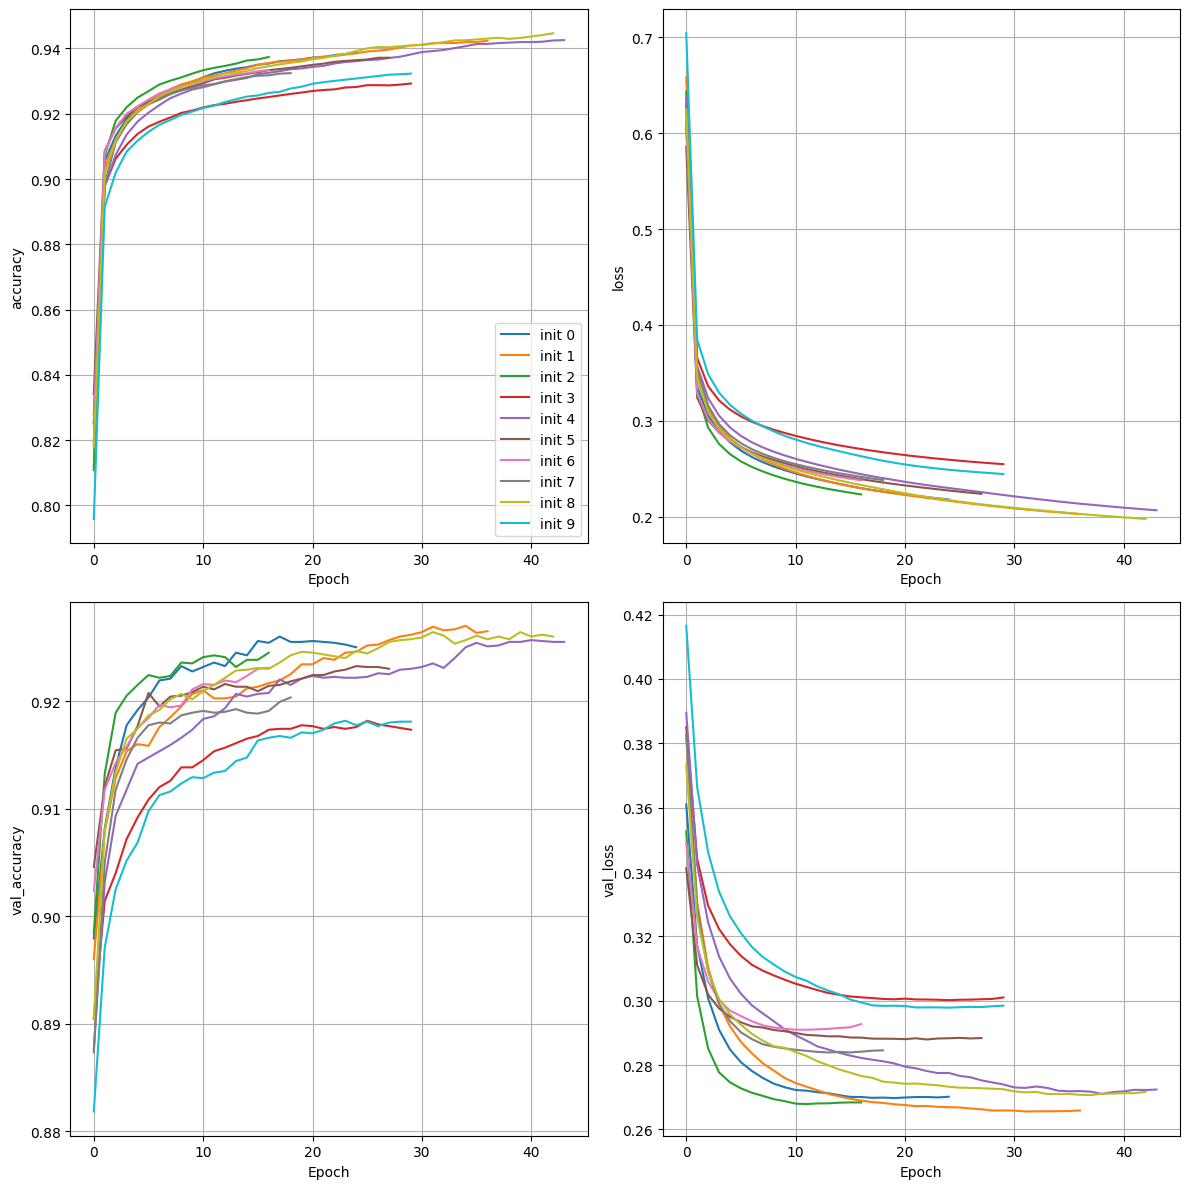

In [9]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
flattened_axes = axes.flatten()
for i, history in enumerate(histories):
    iterator = zip(history['metrics'].items(), flattened_axes)
    for (metric_name, metric_value), ax in iterator:
        if not i:
            ax.grid()
            ax.set_ylabel(metric_name)
            ax.set_xlabel('Epoch')
        ax.plot(metric_value, label=f'init {history["init"]}')
flattened_axes[0].legend()
fig.tight_layout()
fig.savefig(str(output_dir / 'measures_variation.png'), dpi=300)
